In [86]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [87]:
using SpecialFunctions

# import SpecialFunctions: logbeta
# logbeta(x) = sum(loggamma.(x)) - loggamma(sum(x))
  
# Parameters
s = 0.7
d = [1.0, 2.0]
b = [1.0, 1.0]
K = length(b)

# Divergence
function F(β1, β2)
    β = [β1, β2]
    β0 = sum(β)
    b0 = sum(b)

    β = [β1, β2]
    β0 = sum(β)
    b0 = sum(b)

    return -logbeta(β1, β2) + 
                   ((1 - s/β0)*β - b)'*digamma.(β) - 
                   (β0 - s - b0)*digamma(β0) -
                   (s/β0)*(β'*d + K - 1)
end

# Gradient
S = 0.1 # Plot scale
function delβF(β1, β2)
    β = [β1, β2]
    β0 = sum(β)
    b0 = sum(b)

    C   = (s/β0^2)*(β'*digamma.(β) + β'd + K - 1) -
          (β0 - s - b0)*trigamma(β0)
    del = -(s/β0)*digamma.(β) +
          (1 - s/β0)*β.*trigamma.(β) -
          b.*trigamma.(β) -
          (s/β0)*d .+ C

    return S*del # Scaled gradient
end
;

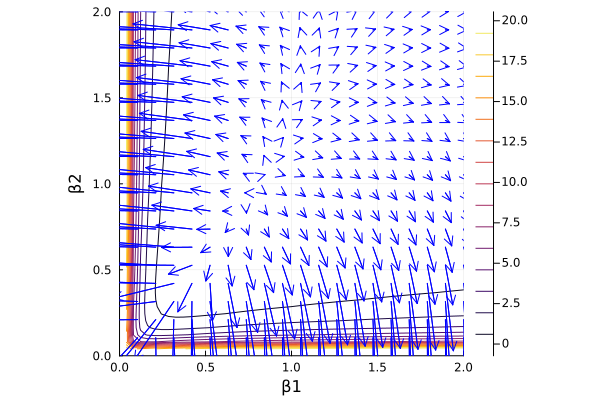

In [88]:
using Plots; gr()

B = 2 # Max plotting range

βs = LinRange(0, B, 50)
contour(βs, βs, F,
        aspect_ratio=:equal, 
        xlim=(0,B), 
        ylim=(0,B), 
        xlabel="β1",
        ylabel="β2")

delβs = LinRange(0, B, 20)
meshgrid(x, y) = (repeat(x, outer=length(y)),
                  repeat(y, inner=length(x)))
B1, B2 = meshgrid(delβs, delβs)
quiver!(B1, B2, quiver=delβF, color=:blue)

In [89]:
using ForwardDiff: jacobian

delβFVec(β) = delβF(β[1], β[2])

# Multivariate root-finding
# β_k = d
# for k=1:10
#     β_k = β_k - inv(jacobian(delβFVec, β_k))*delβFVec(β_k) # Newton step
#     β_k = clamp.(β_k, 0.01, Inf)
# end

# Gradient descent
γ = 0.1
β_k = d
for k=1:100
    β_k = β_k - γ*delβFVec(β_k) # Gradient step
    β_k = clamp.(β_k, 0.01, Inf)
end

println(β_k)

[1.0609679431822323, 1.8636161326570044]


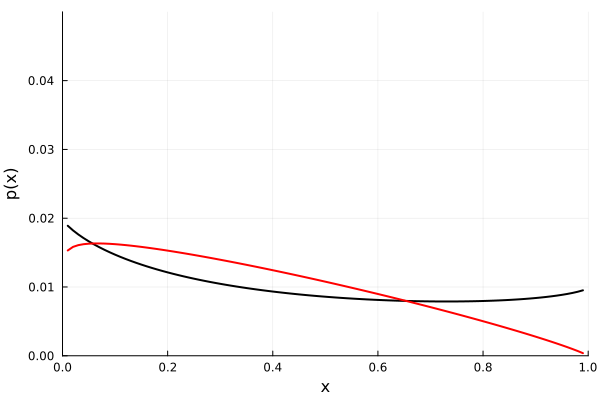

In [90]:
dx = 0.01
xs = dx:dx:(1-dx)
n = length(xs)

# Distributions
function pdf_ep(s, d, b)
    f_ep = zeros(n)
    for j = 1:n
        x_j = [xs[j], 1-xs[j]]
        f_ep[j] = exp.(s*x_j'*log.(x_j.+eps()) + s*x_j'*d + (b .- 1.0)'*log.(x_j.+eps()))
    end

    return f_ep ./ sum(f_ep)
end
  
function pdf_dir(β)
    f_dir = zeros(n)
    for j = 1:n
        x_j = [xs[j], 1-xs[j]]
        f_dir[j] = exp.((β .- 1.0)'*log.(x_j.+eps()))
    end

    return f_dir ./ sum(f_dir)
end

# Univariate Distribution
plt = plot(xs,
           pdf_ep(s, d, b),
           dpi=100,
           xlim=(0,1), 
           ylim=(0,0.05),
           xlabel="x",
           ylabel="p(x)",
           color="black",
           label="",
           lw=2)
plot!(xs, pdf_dir(β_k), lw=2, label="", color="red")